In [96]:
# Imports, as always...
from os import makedirs, path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader

from torch.nn import Module, LSTM, Linear, Softmax
from torch.optim import Adam
from torch.nn import L1Loss, MSELoss

# Date and time information for file saving.
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
current_time = datetime.now().strftime("%H-%M-%S")

# Script imports.
from dataset import load_dataset, load_flipped_dataset, PyTorchDataset

# Graphical imports.
import matplotlib.pyplot as plt
import seaborn as sns

# Styling.
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

# Ignore warnings.
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Random seeds.
torch.manual_seed(42)
np.random.seed(42)

In [3]:
dataset_path = 'martina/data/walkerDataset/all-dataset-1000.npz'
machines = [
    'ibmq_athens', 'ibmq_casablanca', 'ibmq_lima', 'ibmq_quito', 'ibmq_santiago', 'ibmq_5_yorktown'
]
machine_names = [ms.split('_')[-1].capitalize() for ms in machines]

# Fingerprint Forecasting

This notebook looks to capitalise on the sequenced nature of the data to try and forecast the fingerprint of quantum devices, thus providing a model that can predict future (or past) noise. 

Some applications of this that would be interesting:
- *Extrapolation to the origin*. Knowing how the noise fingerprint evolves raises begs the question: can we forecast backwards towards an "origin" time step, where no noise would have been laid? How much time do we need before we can accurately forecast the origin time step? To realise this application, it may only be necessary to reverse the data sequence and predict the next step.
- *Real-time noise mitigation*. Knowing what the noise fingerprint will look like in the future would allow us to anticipate the effects that will have on our future measurements, and perhaps allows us to pre-emptively bias the state before measurement to counteract that effect. 

## Sequence Prediction

This is the task of predicting the next entry in a given sequence. This can be arbitrarily interesting, from guessing the $(k+1)$-th sequence element given $1,\dots,k$, to guessing the $1$-st given $k,\dots,2$.

## Creating the dataset

We'll be needing data of the form $\mathbf{x}_i=(x_i^{(1)},\dots,x_i^{(k-1)}),\mathbf{y}_i=x_i^{(k)}$, for measurement steps $1,\dots,k$. 

In [4]:
# Function to create the datasets for sequence prediction.
def create_sequence_prediction_datasets(steps : np.array, target_step : int, test_size : float, val_size : float, shuffle : bool = True, as_torch : bool = True, batch_size : int = None, seed : int = 42):
    assert target_step in steps, "Target step is not in given measurement steps."
    
    # Setting randomness seeds.
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Load the full sequence.
    all_train, all_val, all_test, _, _, _ = load_dataset(
        dataset_path, 
        steps=steps, 
        test_size=test_size, val_size=val_size,
        shuffle=shuffle,
        as_torch=False
    )
    
    # Separate into sample and target.
    xs_train, ys_train = all_train[:, np.arange(all_train.shape[1]) != target_step, :], all_train[:, target_step, :]
    xs_val, ys_val = all_val[:, np.arange(all_val.shape[1]) != target_step, :], all_val[:, target_step, :]
    xs_test, ys_test = all_test[:, np.arange(all_test.shape[1]) != target_step, :], all_test[:, target_step, :]
    
    # Convert to PyTorch if necessary.
    if as_torch:
        # Dataset objects.
        train_dataset = PyTorchDataset(xs_train, ys_train)
        if val_size > 0: val_dataset = PyTorchDataset(xs_val, ys_val)
        else: val_dataset = None
        if test_size > 0: test_dataset = PyTorchDataset(xs_test, ys_test)
        else: test_dataset = None

        # Convert further into Dataloaders if a batch size is specified.
        if batch_size:
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
            if val_size > 0: val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            else: val_dataloader = None
            if test_size > 0: test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
            else: test_dataloader = None

            return train_dataloader, val_dataloader, test_dataloader

        # Otherwise, a dataset will do.
        return train_dataset, val_dataset, test_dataset

    # Otherwise, return the numpy arrays.
    return xs_train, xs_val, xs_test, ys_train, ys_val, ys_test

In [6]:
# e.g.
train_dataset, val_dataset, _ = create_sequence_prediction_datasets(steps=np.arange(9), target_step=8, test_size=.25, val_size=.15, shuffle=True, as_torch=True, batch_size=None)

for x, y in train_dataset:
    print('Steps 1-8:')
    print(x)
    print('\nStep 9:')
    print(y)
    break

Steps 1-8:
[[0.523 0.473 0.002 0.002]
 [0.33  0.276 0.148 0.246]
 [0.22  0.437 0.147 0.196]
 [0.19  0.477 0.128 0.205]
 [0.226 0.344 0.154 0.276]
 [0.292 0.237 0.245 0.226]
 [0.31  0.247 0.261 0.182]
 [0.313 0.198 0.246 0.243]]

Step 9:
[0.307 0.271 0.231 0.191]


In [13]:
torch.tensor(x).unsqueeze(-1)

torch.Size([8, 4, 1])

In [14]:
train_dataloader, val_dataloader, _ = create_sequence_prediction_datasets(steps=np.arange(9), target_step=8, test_size=.25, val_size=.15, shuffle=True, as_torch=True, batch_size=64)

for xs, ys in train_dataloader:
    print(xs.shape)
    print(xs.unsqueeze(-1).shape)
    break

torch.Size([64, 8, 4])
torch.Size([64, 8, 4, 1])


Note: I haven't checked for a trend in the time series (other than in data exploration), and I further haven't de-trended if there is any trend. 

### LSTM

In [27]:
class LSTMForecaster(Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMForecaster, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Component layers.
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = Linear(in_features=hidden_size, out_features=output_size)
        self.softmax = Softmax()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        
        return out

In [99]:
# Data.
train_dataloader, val_dataloader, _ = create_sequence_prediction_datasets(steps=np.arange(9), target_step=8, test_size=.25, val_size=.15, shuffle=True, as_torch=True, batch_size=64)

# LSTM Forecaster model.
lstm_model = LSTMForecaster(input_size=4, hidden_size=128, num_layers=1, output_size=4)

# Loss function and optimiser.
loss_fn = L1Loss()
optimiser = Adam(lstm_model.parameters(), lr=1e-3)

# Training.
for epoch in tqdm(range(25)):
    running_loss = .0
    
    for xs, ys_true in train_dataloader:
        # Reset gradients.
        optimiser.zero_grad()
        
        # Predict.
        ys_pred = lstm_model(xs)
        
        # Loss.
        loss = loss_fn(ys_pred, ys_true)
        running_loss += loss.item()
        
        # Update weights.
        loss.backward()
        optimiser.step()
        
    print(f'Epoch {epoch+1:03d}: train loss - {running_loss / len(train_dataloader)}')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: train loss - 0.02641848527515928
Epoch 002: train loss - 0.023297771780441203
Epoch 003: train loss - 0.020154983441655835
Epoch 004: train loss - 0.018958563326547544
Epoch 005: train loss - 0.018525179599722226
Epoch 006: train loss - 0.01784823602065444
Epoch 007: train loss - 0.017243628141780695
Epoch 008: train loss - 0.016631159659785528
Epoch 009: train loss - 0.016019134308832388
Epoch 010: train loss - 0.015598870938022931
Epoch 011: train loss - 0.01544890800335755
Epoch 012: train loss - 0.01518800260964781
Epoch 013: train loss - 0.015002257532129686
Epoch 014: train loss - 0.014757383133595188
Epoch 015: train loss - 0.014684912290734549
Epoch 016: train loss - 0.01446324223652482
Epoch 017: train loss - 0.01436498500406742
Epoch 018: train loss - 0.014319753701177737
Epoch 019: train loss - 0.01418041951643924
Epoch 020: train loss - 0.014164739521220326
Epoch 021: train loss - 0.014126175184113283
Epoch 022: train loss - 0.014015039871446788
Epoch 023: train 

In [100]:
example_idx = 0
lstm_model(torch.tensor([train_dataset[example_idx][0]]))[0].detach().numpy().round(3), train_dataset[example_idx][1]

(array([0.315, 0.253, 0.236, 0.196], dtype=float32),
 array([0.307, 0.271, 0.231, 0.191], dtype=float32))

In [104]:
# Function to perform a single training step (i.e. one epoch).
def training_step(model, loader, optimiser, loss_fn):
    # Use train mode.
    model.train()
    
    # Track the running loss.
    running_loss = .0
    
    # Iterate over the loader (if verbose is true, give a progress bar).
    for xs, ys_true in loader:
        # Zero gradients.
        optimiser.zero_grad()
        
        # Predict labels.
        ys_pred = model(xs)
        
        # Compute loss (adding to the running loss) and calculate gradients.
        loss = loss_fn(ys_pred, ys_true)
        running_loss += loss.item()
        loss.backward()
        
        # Adjust weights.
        optimiser.step()
        
    # Return the average loss over the epoch.
    return running_loss / len(loader) 

# Function to evaluate with the given loader (i.e. validation/testing).
def evaluate(model, loader, loss_fn):
    # Use evaluation mode.
    model.eval()
    
    # Track the running loss.
    running_loss = .0
    
    # For evaluation, we do not track gradients.
    with torch.no_grad():
        # Iterate over the loader (if verbose is true, give a progress bar).
        for xs, ys_true in loader:
            # Predict labels.
            ys_pred = model(xs)
            
            # Compute loss (adding to the running loss).
            running_loss += loss_fn(ys_pred, ys_true).item()
            
    # Return the average loss over the loader.
    return running_loss / len(loader)

# Function to perform a full training routine.
def train(model, train_loader, val_loader, n_epochs, lr=1e-3, weight_decay=.0, verbose=False, save_dir=None, save_file_name='model-dict'):
    # Create the save directory.
    if save_dir: makedirs(save_dir, exist_ok=True)
    
    # Set up an optimiser and loss function.
    optimiser = Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = L1Loss()
    
    # Track the best validation loss so that we may return to the best weights on termination.
    best_val_loss = np.inf
    best_state = model.state_dict()
    
    # Remember the training statistics, just in case someone feels like plotting it.
    train_losses, val_losses = [], []
    
    for epoch_idx in (tqdm(np.arange(1, n_epochs + 1), desc='Top-level training') if verbose else np.arange(1, n_epochs + 1)):
        # Train the model.
        train_loss = training_step(model, train_loader, optimiser, loss_fn)
        val_loss = evaluate(model, val_loader, loss_fn)
        
        # Store those stats.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update the best validation loss and remember the model's state.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            
            # Save the model (if a save path has been given).
            if save_dir: torch.save(best_state, path.join(save_dir, f'{save_file_name}.pt'))
        
        # Print the stats (if verbose).
        if verbose:
            print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.3f}, val loss - {val_loss:.3f}')
            
    # Restore the best model in validation.
    model.load_state_dict(best_state)
            
    # Return the stats.
    return train_losses, val_losses

In [105]:
# Data.
train_dataloader, val_dataloader, _ = create_sequence_prediction_datasets(steps=np.arange(9), target_step=8, test_size=.25, val_size=.15, shuffle=True, as_torch=True, batch_size=64)

# LSTM Forecaster model.
lstm_model = LSTMForecaster(input_size=4, hidden_size=128, num_layers=1, output_size=4)

# Training.
train_losses, val_losses = train(lstm_model, train_dataloader, val_dataloader, n_epochs=25, lr=1e-3, verbose=True)

Top-level training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: train loss - 0.026, val loss - 0.025
Epoch 002: train loss - 0.023, val loss - 0.021
Epoch 003: train loss - 0.020, val loss - 0.019
Epoch 004: train loss - 0.019, val loss - 0.019
Epoch 005: train loss - 0.018, val loss - 0.019
Epoch 006: train loss - 0.018, val loss - 0.018
Epoch 007: train loss - 0.017, val loss - 0.017
Epoch 008: train loss - 0.017, val loss - 0.017
Epoch 009: train loss - 0.016, val loss - 0.016
Epoch 010: train loss - 0.016, val loss - 0.016
Epoch 011: train loss - 0.015, val loss - 0.016
Epoch 012: train loss - 0.015, val loss - 0.015
Epoch 013: train loss - 0.015, val loss - 0.015
Epoch 014: train loss - 0.015, val loss - 0.015
Epoch 015: train loss - 0.015, val loss - 0.015
Epoch 016: train loss - 0.014, val loss - 0.015
Epoch 017: train loss - 0.014, val loss - 0.014
Epoch 018: train loss - 0.014, val loss - 0.014
Epoch 019: train loss - 0.014, val loss - 0.014
Epoch 020: train loss - 0.014, val loss - 0.014
Epoch 021: train loss - 0.014, val loss 

In [108]:
example_idx = 75
lstm_model(torch.tensor([train_dataset[example_idx][0]]))[0].detach().numpy().round(3), train_dataset[example_idx][1]

(array([0.288, 0.307, 0.196, 0.209], dtype=float32),
 array([0.272, 0.331, 0.193, 0.204], dtype=float32))

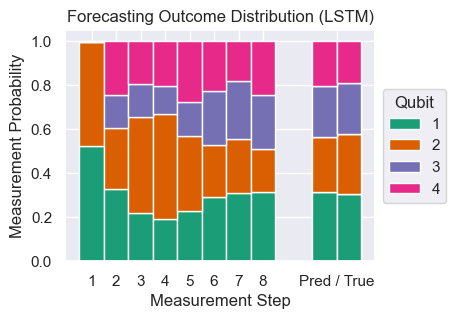

In [242]:
# Let's have a go at plotting that...
example_idx = 0

# Data.
xs, ys_true = train_dataset[example_idx]
ys_pred = lstm_model(torch.tensor([xs])).detach().numpy()
all_probs = np.concatenate((xs, ys_pred, ys_true.reshape(-1, ys_true.shape[0])), axis=0)
example_data = pd.DataFrame({
    'Qubit 1' : all_probs[:, 0], 'Qubit 2' : all_probs[:, 1], 'Qubit 3' : all_probs[:, 2], 'Qubit 4' : all_probs[:, 3],
    'Step' : np.concatenate((np.arange(1, xs.shape[0] + 1), np.arange(xs.shape[0] + 1, xs.shape[0] + ys_pred.shape[0] + 1), np.arange(xs.shape[0] + 1, xs.shape[0] + ys_pred.shape[0] + 1)), axis=None)
})

# Plot.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
palette = sns.color_palette('Dark2', n_colors=xs.shape[1])
width = 1
gap = 2

# Plotting xs.
bottoms_xs = np.zeros(xs.shape[0])
for qubit in np.arange(xs.shape[1]):
    ax.bar(np.arange(xs.shape[0]), all_probs[:-2, qubit], width=width, bottom=bottoms_xs, color=palette[qubit])
    bottoms_xs += all_probs[:-2, qubit]
    
# Side-by-side plotting ys_true and ys_pred.
bottoms_ys_pred = np.zeros(2)
bottoms_ys_true = np.zeros(2)
for qubit in np.arange(ys_pred.shape[1]):
    ax.bar([xs.shape[0] + gap - .5 * width], all_probs[-2,qubit], width=width, bottom=bottoms_ys_pred, color=palette[qubit])
    ax.bar([xs.shape[0] + gap + .5 * width], all_probs[-1,qubit], width=width, bottom=bottoms_ys_true, color=palette[qubit])
    bottoms_ys_pred += all_probs[-2,qubit]
    bottoms_ys_true += all_probs[-1,qubit]

# Beautification.
ax.set_title('Forecasting Outcome Distribution (LSTM)')
ax.set_ylabel('Measurement Probability')
ax.set_xlabel('Measurement Step')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8 + gap], [1, 2, 3, 4, 5, 6, 7, 8, 'Pred / True'])
ax.legend(title='Qubit', labels=[1, 2, 3, 4], loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('./figures/lstm/martina-forecasting-stacked-bar.pdf', bbox_inches='tight')